# Fast SLAM

## 8.3 implement paricle filter

In [1]:
import sys
sys.path.append('../scripts/')
from kf import * # this also import Mcl class

In [2]:
class FastSlam(Mcl):
    def __init__(self, envmap, init_pose, num_particle, num_landmark, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},                  
                 distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(envmap, init_pose, num_particle, motion_noise_stds, distance_dev_rate, direction_dev)

In [3]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug = False)
    
    m = Map()
    for landmark in [(-4,2),(2,-3),(3,3)]: 
        m.append_landmark((Landmark(*landmark)))
    world.append(m)
    
    init_pose = np.array([0,0,0]).T
    num_particle = 100
    fastslam = FastSlam(m, init_pose, num_particle, len(m.landmarks))
    nu = 0.2
    omega = 10.0/180*math.pi
    agent = EstimationAgent(time_interval, nu, omega, fastslam) # in Mcl class
    robot = Robot(init_pose, sensor=Camera(m), agent=agent, color='red')
    world.append(robot)
    
    world.draw()

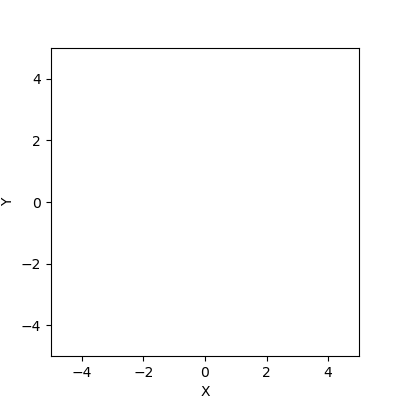

In [4]:
%matplotlib widget
trial()

In [26]:
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0)
        self.cov = np.array([[1,0],[0,2]])
        
    def draw(self, ax, elems):
        if self.cov is None:
            return
        
        center = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(center)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:"+str(self.id), fontsize=10))
        
        ellipse = sigma_ellipse(self,pos, self.cov, 3)
        elems.append(ax.add_patch(ellipse))

In [27]:
class MapParticle(Particle):
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        
        self.map = Map()
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())

In [28]:
class FastSlam(Mcl):
    def __init__(self, envmap, init_pose, num_particle, num_landmark, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2},                  
                 distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(envmap, init_pose, num_particle, motion_noise_stds, distance_dev_rate, direction_dev)
        self.particles = [MapParticle(init_pose, 1.0/num_particle, num_landmark) for i in range(num_particle)]
        self.maxlikelihood = self.particles[0] # temporally
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.maxlikelihood.map.draw(ax, elems)

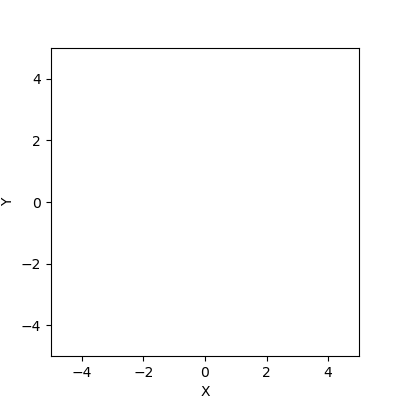

In [30]:
trial()